In [143]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [144]:
WINDOW = 1 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 16

In [145]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-02-05 04:00:00-05:00,211.200000,212.030000,210.850000,212.030000,212.030000,0
2020-02-05 05:00:00-05:00,212.480000,213.000000,212.130000,212.300000,212.300000,0
2020-02-05 06:00:00-05:00,212.150000,212.290000,212.080000,212.200000,212.200000,0
2020-02-05 07:00:00-05:00,212.310000,212.320000,211.700000,212.250000,212.250000,0
2020-02-05 08:00:00-05:00,212.220000,212.710000,211.700100,212.660000,212.660000,0
...,...,...,...,...,...,...
2021-02-04 12:30:00-05:00,265.230011,266.559998,265.154999,266.230011,266.230011,1169964
2021-02-04 13:30:00-05:00,266.260010,266.419891,265.149994,265.176086,265.176086,1056537
2021-02-04 14:30:00-05:00,265.170013,266.125000,264.920013,265.670013,265.670013,2405284


In [146]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-05 04:00:00-05:00,211.200000,212.030000,210.850000,212.030000,212.030000,0
2020-02-05 05:00:00-05:00,212.480000,213.000000,212.130000,212.300000,212.300000,0
2020-02-05 06:00:00-05:00,212.150000,212.290000,212.080000,212.200000,212.200000,0
2020-02-05 07:00:00-05:00,212.310000,212.320000,211.700000,212.250000,212.250000,0
2020-02-05 08:00:00-05:00,212.220000,212.710000,211.700100,212.660000,212.660000,0
2020-02-05 09:00:00-05:00,212.670000,213.200000,212.420000,212.480000,212.480000,0
2020-02-05 09:30:00-05:00,212.509995,212.729996,210.139999,210.414993,210.414993,3634995
2020-02-05 10:30:00-05:00,210.410004,210.410004,208.770004,209.919998,209.919998,1788886
2020-02-05 11:30:00-05:00,209.916794,210.277695,209.600006,209.989807,209.989807,1099488


<AxesSubplot:xlabel='Datetime'>

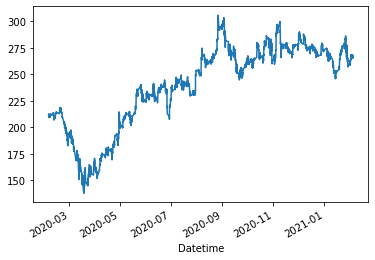

In [147]:
data['close'].plot()

In [148]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [149]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Datetime,,,,,,,,,,,,,,,,,,
2020-02-05 04:00:00-05:00,212.030000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN
2020-02-05 05:00:00-05:00,212.300000,100.000000,0.006058,0.003365,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.000630,1.000621,1.000617,1.000578,NaN
2020-02-05 06:00:00-05:00,212.200000,71.486762,0.004618,0.003879,NaN,0.000000e+00,NaN,NaN,NaN,NaN,19.138756,NaN,NaN,1.000105,1.000098,1.000094,1.000065,NaN
2020-02-05 07:00:00-05:00,212.250000,75.281814,0.005655,0.004480,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-2.364066,NaN,NaN,1.000253,1.000244,1.000240,1.000204,NaN
2020-02-05 08:00:00-05:00,212.660000,88.637182,0.022414,0.009815,NaN,0.000000e+00,NaN,NaN,NaN,NaN,60.083874,NaN,NaN,1.001730,1.001699,1.001682,1.001540,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 12:30:00-05:00,266.230011,48.812125,-0.046570,0.210663,49.666169,7.090101e+09,1.325801,-0.749989,11.489170,-0.221119,-83.343200,1.089967,0.917840,0.997840,0.999883,0.999509,0.999414,1.024798
2021-02-04 13:30:00-05:00,265.176086,43.900248,-0.142515,0.140028,26.193462,7.089094e+09,1.316509,-1.743914,11.883501,-0.683114,-121.480073,1.083560,0.923499,0.994009,0.996110,0.995813,0.996212,0.937089
2021-02-04 14:30:00-05:00,265.670013,46.611711,-0.176660,0.076690,37.194063,7.089990e+09,1.331065,-0.819987,9.553178,-0.490668,-109.288486,1.067411,0.921653,0.995941,0.998057,0.997804,0.998389,1.794404


In [150]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

In [151]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 0.35:
        return 1
    if row['close_shift'] -row['close']< -0.35:
        return -1
    else:
        return 0

In [152]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift
Datetime,,,,,,,,,,,,,,,,,,,
2020-02-05 04:00:00-05:00,212.030000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,212.300000
2020-02-05 05:00:00-05:00,212.300000,100.000000,0.006058,0.003365,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.000630,1.000621,1.000617,1.000578,NaN,212.200000
2020-02-05 06:00:00-05:00,212.200000,71.486762,0.004618,0.003879,NaN,0.000000e+00,NaN,NaN,NaN,NaN,19.138756,NaN,NaN,1.000105,1.000098,1.000094,1.000065,NaN,212.250000
2020-02-05 07:00:00-05:00,212.250000,75.281814,0.005655,0.004480,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-2.364066,NaN,NaN,1.000253,1.000244,1.000240,1.000204,NaN,212.660000
2020-02-05 08:00:00-05:00,212.660000,88.637182,0.022414,0.009815,NaN,0.000000e+00,NaN,NaN,NaN,NaN,60.083874,NaN,NaN,1.001730,1.001699,1.001682,1.001540,NaN,212.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 12:30:00-05:00,266.230011,48.812125,-0.046570,0.210663,49.666169,7.090101e+09,1.325801,-0.749989,11.489170,-0.221119,-83.343200,1.089967,0.917840,0.997840,0.999883,0.999509,0.999414,1.024798,265.176086
2021-02-04 13:30:00-05:00,265.176086,43.900248,-0.142515,0.140028,26.193462,7.089094e+09,1.316509,-1.743914,11.883501,-0.683114,-121.480073,1.083560,0.923499,0.994009,0.996110,0.995813,0.996212,0.937089,265.670013
2021-02-04 14:30:00-05:00,265.670013,46.611711,-0.176660,0.076690,37.194063,7.089990e+09,1.331065,-0.819987,9.553178,-0.490668,-109.288486,1.067411,0.921653,0.995941,0.998057,0.997804,0.998389,1.794404,266.619995


In [153]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,
2020-02-05 04:00:00-05:00,212.030000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,212.300000,0
2020-02-05 05:00:00-05:00,212.300000,100.000000,0.006058,0.003365,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,1.000630,1.000621,1.000617,1.000578,NaN,212.200000,0
2020-02-05 06:00:00-05:00,212.200000,71.486762,0.004618,0.003879,NaN,0.000000e+00,NaN,NaN,NaN,NaN,19.138756,NaN,NaN,1.000105,1.000098,1.000094,1.000065,NaN,212.250000,0
2020-02-05 07:00:00-05:00,212.250000,75.281814,0.005655,0.004480,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-2.364066,NaN,NaN,1.000253,1.000244,1.000240,1.000204,NaN,212.660000,1
2020-02-05 08:00:00-05:00,212.660000,88.637182,0.022414,0.009815,NaN,0.000000e+00,NaN,NaN,NaN,NaN,60.083874,NaN,NaN,1.001730,1.001699,1.001682,1.001540,NaN,212.480000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04 12:30:00-05:00,266.230011,48.812125,-0.046570,0.210663,49.666169,7.090101e+09,1.325801,-0.749989,11.489170,-0.221119,-83.343200,1.089967,0.917840,0.997840,0.999883,0.999509,0.999414,1.024798,265.176086,-1
2021-02-04 13:30:00-05:00,265.176086,43.900248,-0.142515,0.140028,26.193462,7.089094e+09,1.316509,-1.743914,11.883501,-0.683114,-121.480073,1.083560,0.923499,0.994009,0.996110,0.995813,0.996212,0.937089,265.670013,1
2021-02-04 14:30:00-05:00,265.670013,46.611711,-0.176660,0.076690,37.194063,7.089990e+09,1.331065,-0.819987,9.553178,-0.490668,-109.288486,1.067411,0.921653,0.995941,0.998057,0.997804,0.998389,1.794404,266.619995,1


In [154]:
# Class divide
data['class_column'].value_counts()

 1    1421
 0    1378
-1    1343
Name: class_column, dtype: int64

In [155]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [156]:
data['class_column'].value_counts()

 1    1395
 0    1340
-1    1328
Name: class_column, dtype: int64

In [157]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [158]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [159]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [160]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  DecisionTreeClassifier 1
Score:  0.625
Calculate:  DecisionTreeClassifier 2
Score:  0.5625
Calculate:  DecisionTreeClassifier 3
Score:  0.4375
Calculate:  DecisionTreeClassifier 4
Score:  0.3125
Calculate:  DecisionTreeClassifier 5
Score:  0.625
Calculate:  DecisionTreeClassifier 6
Score:  0.3125
Calculate:  DecisionTreeClassifier 7
Score:  0.375
Calculate:  DecisionTreeClassifier 8
Score:  0.25
Calculate:  RandomForestClassifier 1
Score:  0.375
Calculate:  RandomForestClassifier 2
Score:  0.375
Calculate:  RandomForestClassifier 3
Score:  0.375
Calculate:  RandomForestClassifier 4
Score:  0.375
Calculate:  RandomForestClassifier 5
Score:  0.375
Calculate:  RandomForestClassifier 6
Score:  0.375
Calculate:  RandomForestClassifier 7
Score:  0.375
Calculate:  RandomForestClassifier 8
Score:  0.375
Calculate:  GradientBoostingClassifier 1
Score:  0.375
Calculate:  GradientBoostingClassifier 2
Score:  0.375
Calculate:  GradientBoostingClassifier 3
Score:  0.375
Calculate:  Grad

In [173]:
estimators=[
            ('GBC12', classifiers['GradientBoostingClassifier 12']),
            ('DTC1', classifiers['DecisionTreeClassifier 1']),
            ]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(x_train, y_train)
predicted = ensemble.predict(x_test)
score_ensemble = accuracy_score(y_test.values, predicted)
print('Score: ',  score_ensemble)

Score:  0.6875


In [174]:
print('Score: ',  score_ensemble)

Score:  0.6875
